In [1]:
import cv2
import numpy as np
import pandas as pd
import scipy.stats as ss
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch.utils.data as data

import scipy.stats as ss

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
from tqdm.notebook import trange, tqdm

from PIL import Image, ImageDraw, ImageFont
import PIL

import os

import copy
import random
import time

%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('./data')

Mounted at ./data


In [3]:
!cp /content/data/MyDrive/ColabNotebooks/Doc_recognition/Passports/pre_train.py /content
!cp /content/data/MyDrive/ColabNotebooks/Doc_recognition/Passports/models.py /content

In [4]:
import pre_train as pt
from models import CNNModelOneConv, CNNModelTwoConv

In [5]:
PREFIX = "data/MyDrive/ColabNotebooks/Doc_recognition/Passports/"

In [6]:
data = pd.read_csv(PREFIX + "dataset/Passports.csv")
data.head()

Unnamed: 0      file_name    H    W  channels  \
0           0  passport0.jpg  731  522         3   
1           1  passport1.jpg  731  522         3   
2           2  passport2.jpg  731  522         3   
3           3  passport3.jpg  731  522         3   
4           4  passport4.jpg  731  522         3   

                                                 dep      p_date     code  \
0  ОТДЕЛОМ УФМС РОССИИ ПО КАЛУЖСКОЙ ОБЛ. В МАЛОЯР...  22.09.2014  400-017   
1                        ОКТЯБРЬСКИМ РУВД Г. ТАМБОВА  07.11.2018  682-016   
2                   ГУ МВД РОССИИ ПО РОСТОВСКОЙ ОБЛ.  01.01.2022  610-030   
3  ОВД ДИГОРСКОГО РАЙОНА РЕСП. СЕВЕРНАЯ ОСЕТИЯ-АЛ...  05.07.2017  152-007   
4  УСПЕНСКИМ ПОСЕЛКОВЫМ ОМ ОДИНЦОВСКОГО РАЙОНА МО...  26.12.2019  503-068   

    surname      name  ... b_place3-right-x b_place3-right-y up-left-x  \
0  ИЗМАЙЛОВ    РУСТАМ  ...              470              615        22   
1   ФИЛАТОВ    ПЛАТОН  ...              470              615        22   
2   ТАРАСОВ   АЛЬБЕРТ  ...              470              615        22   
3   ФИЛАТОВ    КИРИЛЛ  ...              470              615        22   
4    КАРПОВ  ВЛАДИМИР  ...              470              615        22   

  up-left-y  up-right-x  up-right-y  bottom-left-x  bottom-left-y  \
0       430         168         430             22            618   
1       430         168         430             22            618   
2       430         168         430             22            618   
3       430         168         430             22            618   
4       430         168         430             22            618   

   bottom-right-x  bottom-right-y  
0             168             618  
1             168             618  
2             168             618  
3             168             618  
4             168             618  

[5 rows x 78 columns]

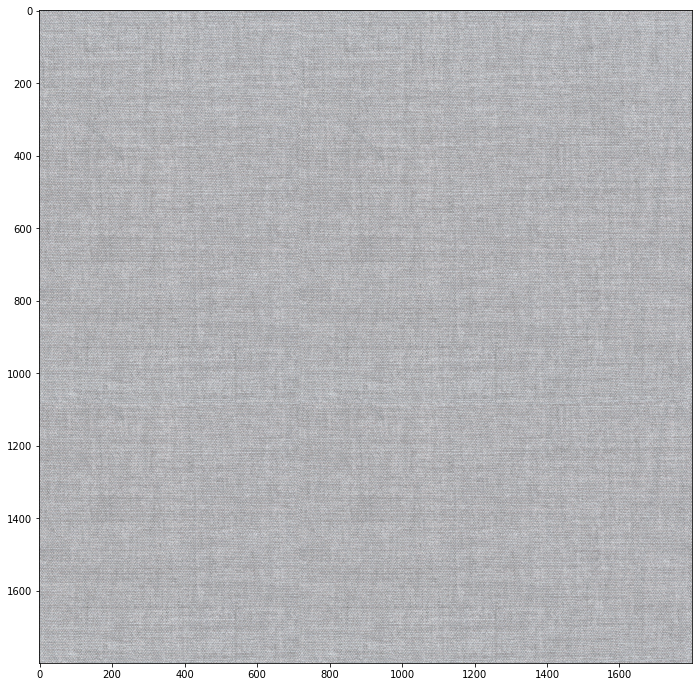

In [7]:
backgrounds = os.listdir(PREFIX + "photo_data/backgrounds")
backs = []

for bg in backgrounds:
    backs.append(PIL.Image.open(PREFIX + "photo_data/backgrounds/" + bg))
    size_0 = backs[-1].size

    backs[-1] = backs[-1].resize((size_0[0], size_0[0]))

ind = np.random.randint(len(backgrounds))
plt.figure(figsize=(12, 12))
plt.imshow(backs[ind])

In [8]:
images = os.listdir(PREFIX + "dataset/images")
np.random.shuffle(images)

RATIO = 0.9
train_inds = np.array([900])
valid_inds = np.array([901, 1000])

# Теперь попробуем что-нибудь обучить

## 1 convolution layer VS 2 convlution layers

In [9]:
Models = [CNNModelOneConv, CNNModelTwoConv]
Info = []
OUTPUT_DIM = 61
EPOCHS = 30

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
model2 = Models[1](OUTPUT_DIM)
Info.append({"Loss": [], "L1": [], "Time": [], "Parameters": 0})
Info[-1]["Parameters"] = pt.count_parameters(model2)

optimizer = optim.Adam(params=model2.parameters(), lr=0.003)
criterion = nn.CrossEntropyLoss()
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

best_valid_loss = float('inf')

train_gen = pt.Generator(n_classes=61, batch_size=32, PREFIX=PREFIX)
valid_gen = pt.Generator(n_classes=61, batch_size=32, PREFIX=PREFIX)

for epoch in range(EPOCHS):


    start_time = time.monotonic()

    train_gen.initialize(backs, images[:300])
    train_loss, train_acc = pt.train(model2, train_gen, optimizer, criterion, device)

    valid_gen.initialize(backs, images[300:500])
    valid_loss, valid_acc, l1_loss = pt.evaluate(model2, valid_gen, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model2.state_dict(), 'tut1-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = pt.epoch_time(start_time, end_time)

    Info[-1]["Loss"].append(valid_loss)
    Info[-1]["L1"].append(l1_loss)
    Info[-1]["Time"].append(end_time - start_time)
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}% |  Val. Acc: {l1_loss*1:.2f}')

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 1m 22s
	Train Loss: 4.475 | Train Acc: 6.56%
	 Val. Loss: 6.817 |  Val. Acc: 3.12% |  Val. Acc: 14.76


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 1m 0s
	Train Loss: 5.256 | Train Acc: 6.35%
	 Val. Loss: 10.725 |  Val. Acc: 0.45% |  Val. Acc: 27.75


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 55s
	Train Loss: 3.947 | Train Acc: 8.85%
	 Val. Loss: 12.541 |  Val. Acc: 1.34% |  Val. Acc: 26.35


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 58s
	Train Loss: 3.461 | Train Acc: 14.48%
	 Val. Loss: 3.533 |  Val. Acc: 8.48% |  Val. Acc: 6.02


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 55s
	Train Loss: 3.055 | Train Acc: 14.69%
	 Val. Loss: 5.657 |  Val. Acc: 7.14% |  Val. Acc: 17.98


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 55s
	Train Loss: 2.694 | Train Acc: 22.08%
	 Val. Loss: 5.555 |  Val. Acc: 9.82% |  Val. Acc: 9.70


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 1m 0s
	Train Loss: 2.516 | Train Acc: 24.27%
	 Val. Loss: 2.081 |  Val. Acc: 25.89% |  Val. Acc: 1.01


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 55s
	Train Loss: 2.333 | Train Acc: 27.29%
	 Val. Loss: 12.255 |  Val. Acc: 4.46% |  Val. Acc: 22.92


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 55s
	Train Loss: 2.200 | Train Acc: 29.90%
	 Val. Loss: 5.490 |  Val. Acc: 19.64% |  Val. Acc: 6.76


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 57s
	Train Loss: 2.190 | Train Acc: 24.58%
	 Val. Loss: 1.586 |  Val. Acc: 41.07% |  Val. Acc: 0.73


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 11 | Epoch Time: 1m 1s
	Train Loss: 2.092 | Train Acc: 34.58%
	 Val. Loss: 4.558 |  Val. Acc: 20.54% |  Val. Acc: 9.91


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 55s
	Train Loss: 1.826 | Train Acc: 38.65%
	 Val. Loss: 1.703 |  Val. Acc: 51.34% |  Val. Acc: 0.67


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 13 | Epoch Time: 0m 58s
	Train Loss: 1.769 | Train Acc: 41.67%
	 Val. Loss: 1.265 |  Val. Acc: 52.68% |  Val. Acc: 0.59


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 55s
	Train Loss: 1.624 | Train Acc: 46.04%
	 Val. Loss: 3.450 |  Val. Acc: 23.21% |  Val. Acc: 13.05


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 15 | Epoch Time: 0m 54s
	Train Loss: 1.498 | Train Acc: 44.90%
	 Val. Loss: 4.184 |  Val. Acc: 27.68% |  Val. Acc: 11.78


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 0m 54s
	Train Loss: 1.310 | Train Acc: 51.88%
	 Val. Loss: 1.580 |  Val. Acc: 50.45% |  Val. Acc: 2.54


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 17 | Epoch Time: 0m 58s
	Train Loss: 1.251 | Train Acc: 57.19%
	 Val. Loss: 3.405 |  Val. Acc: 35.27% |  Val. Acc: 9.54


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 0m 57s
	Train Loss: 1.106 | Train Acc: 59.90%
	 Val. Loss: 0.923 |  Val. Acc: 68.75% |  Val. Acc: 0.39


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 19 | Epoch Time: 0m 57s
	Train Loss: 0.945 | Train Acc: 65.62%
	 Val. Loss: 0.442 |  Val. Acc: 82.59% |  Val. Acc: 0.20


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 0m 57s
	Train Loss: 0.660 | Train Acc: 77.29%
	 Val. Loss: 0.268 |  Val. Acc: 95.54% |  Val. Acc: 0.05


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 21 | Epoch Time: 0m 59s
	Train Loss: 0.762 | Train Acc: 77.92%
	 Val. Loss: 0.149 |  Val. Acc: 97.32% |  Val. Acc: 0.03


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 22 | Epoch Time: 0m 59s
	Train Loss: 0.473 | Train Acc: 85.42%
	 Val. Loss: 0.208 |  Val. Acc: 93.75% |  Val. Acc: 0.06


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 23 | Epoch Time: 0m 54s
	Train Loss: 0.471 | Train Acc: 85.52%
	 Val. Loss: 0.924 |  Val. Acc: 75.89% |  Val. Acc: 1.47


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 24 | Epoch Time: 0m 54s
	Train Loss: 0.400 | Train Acc: 86.15%
	 Val. Loss: 0.170 |  Val. Acc: 95.98% |  Val. Acc: 0.04


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 25 | Epoch Time: 0m 54s
	Train Loss: 0.408 | Train Acc: 90.73%
	 Val. Loss: 0.568 |  Val. Acc: 77.23% |  Val. Acc: 0.88


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 26 | Epoch Time: 0m 59s
	Train Loss: 0.321 | Train Acc: 87.29%
	 Val. Loss: 0.095 |  Val. Acc: 98.66% |  Val. Acc: 0.01


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 27 | Epoch Time: 0m 54s
	Train Loss: 0.176 | Train Acc: 94.58%
	 Val. Loss: 0.163 |  Val. Acc: 96.43% |  Val. Acc: 0.36


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 28 | Epoch Time: 0m 57s
	Train Loss: 0.214 | Train Acc: 92.81%
	 Val. Loss: 0.014 |  Val. Acc: 100.00% |  Val. Acc: 0.00


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 29 | Epoch Time: 0m 54s
	Train Loss: 0.171 | Train Acc: 95.10%
	 Val. Loss: 0.023 |  Val. Acc: 100.00% |  Val. Acc: 0.00


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 30 | Epoch Time: 0m 54s
	Train Loss: 0.261 | Train Acc: 96.25%
	 Val. Loss: 0.055 |  Val. Acc: 99.55% |  Val. Acc: 0.01


In [ ]:
test_gen = pt.Generator(n_classes=61, batch_size=32, PREFIX=PREFIX)
test_gen.initialize(backs, images[500:])
pt.evaluate(model2, test_gen, criterion, device)

In [31]:
# with open(PREFIX + "Experiments/models_info_2.txt", "w") as out:
#     for M in Info:
#         if len(M["L1"]) == 0:
#             continue
#         for key, val in M.items():
#             out.write(key)
#             out.write(str(val) + '\n')
#         out.write('\n')

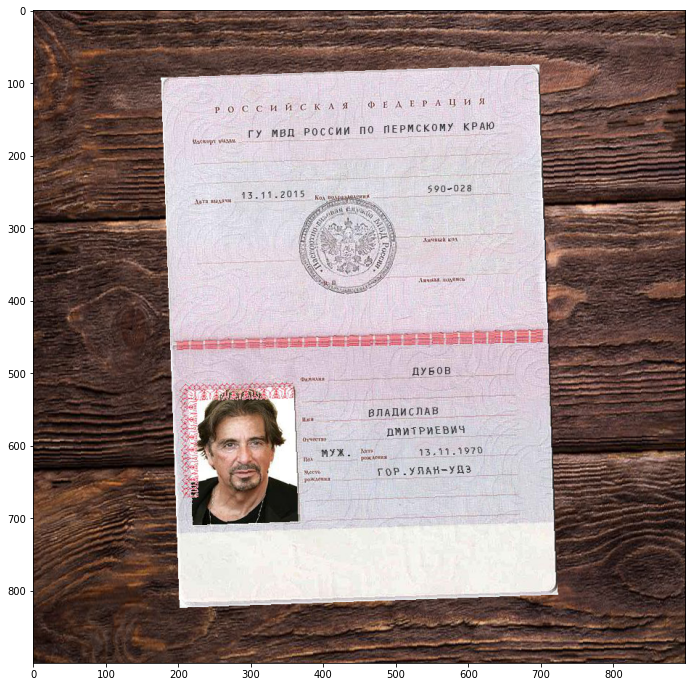

In [ ]:
passport = PIL.Image.open(PREFIX + f"dataset/images/passport{np.random.randint(400, 1000)}.jpg")
rotated = pt.crop_rotate(backs[0], passport, 2)
plt.figure(figsize=(12, 12))
plt.imshow(rotated)

rotated = rotated.resize((224, 224))
rotated = np.array(rotated)

In [ ]:
rotated_np = np.array([[
                    rotated[:, :, 0].reshape(rotated.shape[0], rotated.shape[1]), 
                    rotated[:, :, 1].reshape(rotated.shape[0], rotated.shape[1]), 
                    rotated[:, :, 2].reshape(rotated.shape[0], rotated.shape[1])
                ]])
x_test = torch.from_numpy(rotated_np).type(torch.FloatTensor)
train_gen.get_prediction(np.array(model(x_test).detach()).argmax())

2.0

## MobileNet

In [21]:
from torchvision.models.mobilenet import mobilenet_v2

In [22]:
mobile_net = mobilenet_v2(pretrained=True)
mobile_net.classifier[1] = torch.nn.Linear(in_features=mobile_net.classifier[1].in_features, out_features=61)

optimizer = optim.Adam(params=mobile_net.parameters(), lr=0.003)
criterion = nn.CrossEntropyLoss()

exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [23]:
mobile_net.eval()
mobile_net = mobile_net.to(device)
criterion = criterion.to(device)

In [24]:
pt.count_parameters(mobile_net)

2302013

In [26]:
Info.append({"Loss": [], "L1": [], "Time": [], "Parameters": 0})
Info[-1]["Parameters"] = pt.count_parameters(mobile_net)

preprocess = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

EPOCHS = 40

best_valid_loss = float('inf')
train_gen = pt.Generator(n_classes=61, batch_size=32, preprocessor=preprocess, PREFIX=PREFIX)
valid_gen = pt.Generator(n_classes=61, batch_size=32, preprocessor=preprocess, PREFIX=PREFIX)

for epoch in range(EPOCHS):

    train_gen.initialize(backs, images[:300])
    valid_gen.initialize(backs, images[300:500])

    start_time = time.monotonic()

    train_loss, train_acc = pt.train(
        mobile_net, 
        train_gen, 
        optimizer, 
        criterion, 
        device
    )
    
    valid_loss, valid_acc, l1_loss = pt.evaluate(
        mobile_net, 
        valid_gen, 
        criterion, 
        device
    )

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(mobile_net.state_dict(), 'tut1-model.pt')

    end_time = time.monotonic()

    Info[-1]["Loss"].append(valid_loss)
    Info[-1]["L1"].append(l1_loss)
    Info[-1]["Time"].append(end_time - start_time)

    epoch_mins, epoch_secs = pt.epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}% | L1: {l1_loss*1:.2f}')

Training:   0%|          | 0/10 [00:00<?, ?it/s]

/content/pre_train.py:109: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  batch_x.append(self.transform(self.PREFIX + "dataset/images/" + images[self.batch_size * n + i], np.random.choice(backgrounds), alpha))
/content/pre_train.py:109: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  batch_x.append(self.transform(self.PREFIX + "dataset/images/" + images[self.batch_size *

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 1m 41s
	Train Loss: 4.543 | Train Acc: 2.81%
	 Val. Loss: 9.443 |  Val. Acc: 1.79% | L1: 13.35


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 1m 25s
	Train Loss: 3.581 | Train Acc: 7.92%
	 Val. Loss: 5.534 |  Val. Acc: 10.71% | L1: 11.91


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 1m 29s
	Train Loss: 3.228 | Train Acc: 9.58%
	 Val. Loss: 4.295 |  Val. Acc: 8.93% | L1: 13.77


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 1m 24s
	Train Loss: 2.993 | Train Acc: 11.35%
	 Val. Loss: 4.184 |  Val. Acc: 7.59% | L1: 7.51


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 1m 22s
	Train Loss: 2.901 | Train Acc: 14.06%
	 Val. Loss: 3.130 |  Val. Acc: 8.04% | L1: 3.48


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 1m 24s
	Train Loss: 2.686 | Train Acc: 12.50%
	 Val. Loss: 3.812 |  Val. Acc: 6.25% | L1: 4.04


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 1m 23s
	Train Loss: 2.745 | Train Acc: 13.75%
	 Val. Loss: 3.278 |  Val. Acc: 9.38% | L1: 4.12


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 1m 23s
	Train Loss: 2.709 | Train Acc: 13.54%
	 Val. Loss: 2.535 |  Val. Acc: 18.75% | L1: 2.01


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 1m 25s
	Train Loss: 2.624 | Train Acc: 13.54%
	 Val. Loss: 2.249 |  Val. Acc: 13.84% | L1: 1.81


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 1m 27s
	Train Loss: 2.497 | Train Acc: 15.73%
	 Val. Loss: 2.350 |  Val. Acc: 19.64% | L1: 1.87


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 11 | Epoch Time: 1m 26s
	Train Loss: 2.399 | Train Acc: 19.79%
	 Val. Loss: 2.570 |  Val. Acc: 12.95% | L1: 2.18


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 1m 23s
	Train Loss: 2.362 | Train Acc: 15.62%
	 Val. Loss: 2.272 |  Val. Acc: 22.32% | L1: 1.32


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 13 | Epoch Time: 1m 27s
	Train Loss: 2.298 | Train Acc: 24.17%
	 Val. Loss: 2.166 |  Val. Acc: 17.86% | L1: 1.61


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 1m 23s
	Train Loss: 2.330 | Train Acc: 17.92%
	 Val. Loss: 2.289 |  Val. Acc: 11.61% | L1: 2.06


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 15 | Epoch Time: 1m 24s
	Train Loss: 2.146 | Train Acc: 22.50%
	 Val. Loss: 2.543 |  Val. Acc: 15.18% | L1: 2.27


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 1m 25s
	Train Loss: 2.305 | Train Acc: 21.56%
	 Val. Loss: 2.185 |  Val. Acc: 21.88% | L1: 1.62


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 17 | Epoch Time: 1m 24s
	Train Loss: 2.043 | Train Acc: 24.79%
	 Val. Loss: 2.228 |  Val. Acc: 22.32% | L1: 1.62


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 1m 26s
	Train Loss: 2.100 | Train Acc: 20.83%
	 Val. Loss: 1.888 |  Val. Acc: 18.30% | L1: 1.23


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 19 | Epoch Time: 1m 24s
	Train Loss: 1.958 | Train Acc: 27.29%
	 Val. Loss: 3.254 |  Val. Acc: 9.38% | L1: 3.06


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 1m 25s
	Train Loss: 2.086 | Train Acc: 19.79%
	 Val. Loss: 2.070 |  Val. Acc: 20.09% | L1: 1.56


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 21 | Epoch Time: 1m 25s
	Train Loss: 1.947 | Train Acc: 26.56%
	 Val. Loss: 2.312 |  Val. Acc: 17.86% | L1: 5.63


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 22 | Epoch Time: 1m 22s
	Train Loss: 1.895 | Train Acc: 24.06%
	 Val. Loss: 1.718 |  Val. Acc: 33.48% | L1: 1.14


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 23 | Epoch Time: 1m 24s
	Train Loss: 1.973 | Train Acc: 24.06%
	 Val. Loss: 2.227 |  Val. Acc: 20.09% | L1: 1.97


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 24 | Epoch Time: 1m 23s
	Train Loss: 1.821 | Train Acc: 29.38%
	 Val. Loss: 2.030 |  Val. Acc: 29.02% | L1: 4.26


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 25 | Epoch Time: 1m 22s
	Train Loss: 2.006 | Train Acc: 26.04%
	 Val. Loss: 2.248 |  Val. Acc: 24.55% | L1: 3.44


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 26 | Epoch Time: 1m 24s
	Train Loss: 1.985 | Train Acc: 26.88%
	 Val. Loss: 3.191 |  Val. Acc: 15.18% | L1: 2.66


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 27 | Epoch Time: 1m 22s
	Train Loss: 1.971 | Train Acc: 27.08%
	 Val. Loss: 7.945 |  Val. Acc: 12.95% | L1: 9.79


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 28 | Epoch Time: 1m 24s
	Train Loss: 1.890 | Train Acc: 28.75%
	 Val. Loss: 2.862 |  Val. Acc: 23.21% | L1: 5.75


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 29 | Epoch Time: 1m 22s
	Train Loss: 1.799 | Train Acc: 30.21%
	 Val. Loss: 1.718 |  Val. Acc: 29.91% | L1: 1.20


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 30 | Epoch Time: 1m 24s
	Train Loss: 1.718 | Train Acc: 31.35%
	 Val. Loss: 1.858 |  Val. Acc: 28.12% | L1: 3.56


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 31 | Epoch Time: 1m 23s
	Train Loss: 1.636 | Train Acc: 33.23%
	 Val. Loss: 1.700 |  Val. Acc: 29.91% | L1: 1.77


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 32 | Epoch Time: 1m 22s
	Train Loss: 1.505 | Train Acc: 39.79%
	 Val. Loss: 1.599 |  Val. Acc: 36.16% | L1: 1.68


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 33 | Epoch Time: 1m 23s
	Train Loss: 1.342 | Train Acc: 46.88%
	 Val. Loss: 1.228 |  Val. Acc: 54.46% | L1: 0.61


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 34 | Epoch Time: 1m 22s
	Train Loss: 1.372 | Train Acc: 50.31%
	 Val. Loss: 1.978 |  Val. Acc: 35.27% | L1: 2.32


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 35 | Epoch Time: 1m 23s
	Train Loss: 1.570 | Train Acc: 38.96%
	 Val. Loss: 2.427 |  Val. Acc: 26.34% | L1: 4.75


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 36 | Epoch Time: 1m 24s
	Train Loss: 1.445 | Train Acc: 44.48%
	 Val. Loss: 1.675 |  Val. Acc: 40.62% | L1: 1.76


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 37 | Epoch Time: 1m 22s
	Train Loss: 1.330 | Train Acc: 49.06%
	 Val. Loss: 2.024 |  Val. Acc: 28.12% | L1: 3.63


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 38 | Epoch Time: 1m 24s
	Train Loss: 1.220 | Train Acc: 52.50%
	 Val. Loss: 2.021 |  Val. Acc: 41.96% | L1: 2.48


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 39 | Epoch Time: 1m 21s
	Train Loss: 1.254 | Train Acc: 55.52%
	 Val. Loss: 1.340 |  Val. Acc: 49.55% | L1: 0.73


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 40 | Epoch Time: 1m 23s
	Train Loss: 0.980 | Train Acc: 65.73%
	 Val. Loss: 0.975 |  Val. Acc: 64.29% | L1: 0.70


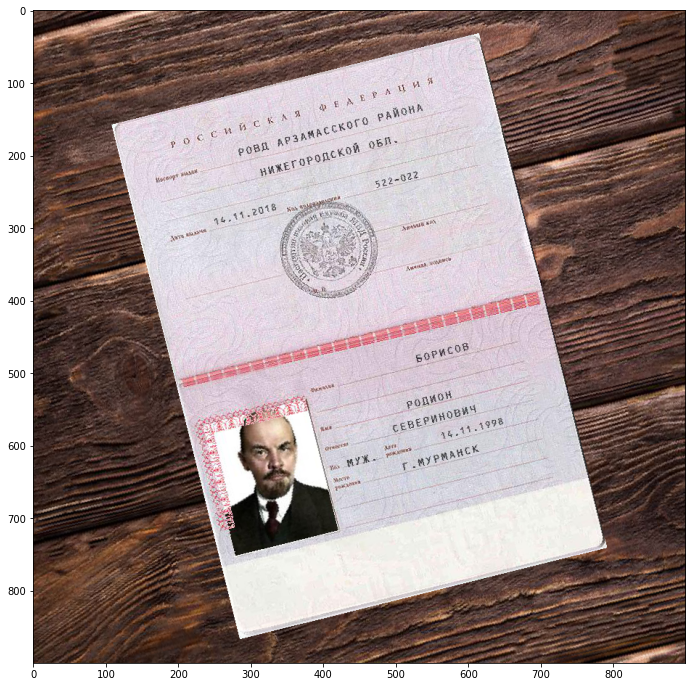

In [ ]:
passport = PIL.Image.open(PREFIX + f"dataset/images/passport{np.random.randint(1000)}.jpg")
rotated = pt.crop_rotate(backs[0], passport, 14)
plt.figure(figsize=(12, 12))
plt.imshow(rotated)

rotated = rotated.resize((224, 224))
rotated = np.array(rotated)

In [ ]:
rotated_np = np.array([[
                    rotated[:, :, 0].reshape(rotated.shape[0], rotated.shape[1]), 
                    rotated[:, :, 1].reshape(rotated.shape[0], rotated.shape[1]), 
                    rotated[:, :, 2].reshape(rotated.shape[0], rotated.shape[1])
                ]])
x_test = preprocess(torch.from_numpy(rotated_np).type(torch.FloatTensor))
np.array(mobile_net(x_test).detach()).argmax() - 30

14

In [ ]:
test_gen = pt.Generator(backs, images[400:], n_classes=30, batch_size=32)
pt.evaluate(mobile_net, test_gen, criterion, device)


## Графики

In [33]:
labels = ["1 conv", "2 conv", "mobile net"]
l1_loss = []
times = []

from dataclasses import field
with open(PREFIX + "Experiments/models_info_2.txt", "r") as file:
    for line in file:
        if line.startswith("L1"):
            loss = list(line[2:].strip('[]\n').split(", "))
            if len(loss) > 1:
                l1_loss.append(list(map(float, loss)))
        if line.startswith("Time"):
            times_ = list(line[4:].strip('[]\n').split(", "))
            if len(times_) > 1:
                times.append(list(map(float, times_)))

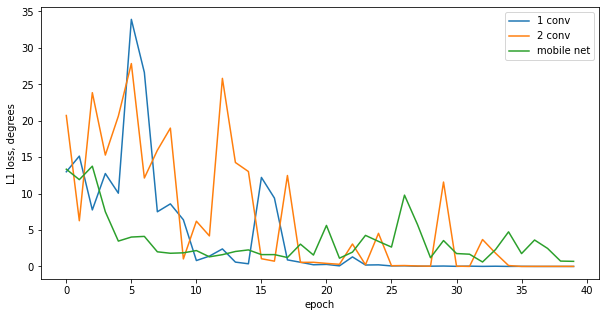

In [37]:
plt.figure(figsize=(10, 5))

for i, label in enumerate(labels):
    plt.plot(np.arange(len(l1_loss[i])), l1_loss[i], label=label)
plt.xlabel("epoch")
plt.ylabel("L1 loss, degrees")
plt.legend()
plt.show()

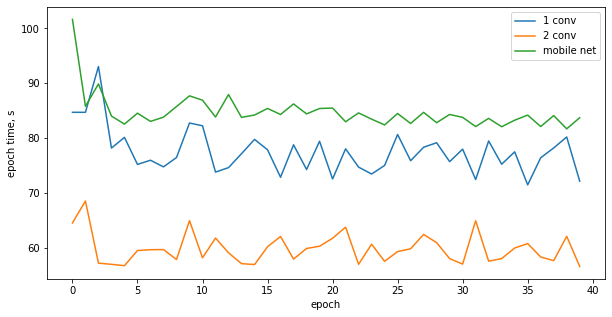

In [39]:
plt.figure(figsize=(10, 5))

for i, label in enumerate(labels):
    plt.plot(np.arange(len(times[i])), times[i], label=label)
plt.xlabel("epoch")
plt.ylabel("epoch time, s")
plt.legend()
plt.show()

## Побеждает модель с двумя свёрточными слоями  
- У неё хорошее качество  
- Она чуть более устойчива к переобучению, чем модель с одним свёрточным слоем  
- Она существенно быстрее!